Setup data

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re
import iris
from ascend import shape
from glob import glob as glob
# works in SCITOOLS Default/next (2021-03-18)

In [4]:
# global variables to control everything
RECIPE_RUN = 'recipe_GCM_and_RCM_CEE-3_20211207_125543'
BASE_PATH = f'/home/h02/tcrocker/code/EUCP_WP5_Lines_of_Evidence/esmvaltool/esmvaltool_output/{RECIPE_RUN}/work/boxplots/main/'
SEASON = 'JJA'
# TODO setup dictionary linking RECIPE_RUN to variable.
VAR = "tas"
AREA = re.search(r'[A-Z]{3}-3', RECIPE_RUN)[0]
# Path to my custom ClimWIP data
CLIMWIP_PATH = '/home/h02/tcrocker/code/EUCP_WP5_Lines_of_Evidence/weighting_data/ClimWIP/'#pr_weighted_CMIP5_Romania_1995-2014_2041-2060.nc'


In [221]:
def box_plot(data, ax, edge_color, fill_color, positions, widths):
    bp = ax.boxplot(data, patch_artist=True, positions = positions, widths=widths, showfliers=False, whis=[10,90])
    
    for element in ['boxes', 'whiskers', 'fliers', 'means', 'medians', 'caps']:
        if element == 'medians':
            col = 'black'
        else:
            col = edge_color
        plt.setp(bp[element], color=col)

    for patch in bp['boxes']:
        patch.set(facecolor=fill_color)       
        
    return bp


def bxp(data, ax, colour, alpha, position, width, **kwargs):
    bp = ax.bxp(data, patch_artist=True, positions=position, widths=width, showfliers=False, **kwargs)
    for element in ['boxes', 'whiskers', 'fliers', 'means', 'medians', 'caps']:
        if element == 'medians':
            col = 'black'
        else:
            col = colour
        plt.setp(bp[element], color=col)
        plt.setp(bp[element], alpha=alpha)

    for patch in bp['boxes']:
        patch.set(facecolor=colour)
        patch.set(alpha = alpha)   
        
    return bp

    
def create_x_points(ys, basex, offset):
    xs = []
    for i, v in enumerate(ys):
        if i == 0:
            xs.append(basex)
            vm1 = v
        else:
            if abs(v - vm1) <= 1:
                if xs[i-1] < basex:
                    xs.append(basex + offset)
                elif xs[i-1] == basex:
                    xs[i-1] = basex - offset
                    xs.append(basex + offset)
                else:
                    # previous version has been offset positively
                    xs.append(basex - offset)
            else:
                xs.append(basex)
            vm1 = v
    
    return xs

def mask_wp2_atlas_data(cube, shp):
    # mask wp2 data using shape file
    
    # approach varies depending on if cube is downloaded from WP2 atlas
    # or direct from Glen's folders
    if cube.ndim == 4:
        # first get lat / lon mask over 2 dimensions
        xy_mask = np.logical_not(shp.cube_intersection_mask(cube[0,:,:,0]))
        # broadcast to 3d
        xyp_mask = np.broadcast_to(xy_mask[:,:,np.newaxis], cube.shape[1:])
        # broadcast to 4d
        cube_mask = np.broadcast_to(xyp_mask, cube.shape)
    else:
        # 3 dimensional (lat, lon, percentile)
        # get 2d mask
        xy_mask = np.logical_not(shp.cube_intersection_mask(cube[:,:,0]))
        # broadcast to 3d
        cube_mask = np.broadcast_to(xy_mask[:,:,np.newaxis], cube.shape)

    # apply to cube
    # combine with existing mask
    cube_mask = np.logical_or(cube_mask, cube.data.mask)
    cube.data.mask = cube_mask

    return cube


def load_wp2_atlas(method, var, area, season):
    # load netCDF file
    base_path = "/net/home/h02/tcrocker/code/EUCP_WP5_Lines_of_Evidence/weighting_data/WP2_atlas"

    # define region constraint if lat and lon supplied
    if type(area) == list:
        region = iris.Constraint(
            longitude = lambda x: area[0] <= x <= area[1],
            latitude = lambda x: area[2] <= x <= area[3]
        )

    bxp_obs = []
    for data in ["cons", "uncons"]:
        fname = f"{base_path}/atlas_EUCP_{method}_{data}_{var}.nc"
        
        cube = iris.load_cube(fname)

        # extract shape / region
        if type(area) == list:
            cube = cube.extract(region)
        else:
            cube = mask_wp2_atlas_data(cube, area)

        if season == "JJA":
            # use first time point (JJA)
            cube = cube[0]
        elif season == "DJF":
            cube = cube[1]
        else:
            raise ValueError("Only JJA and DJF available.")

        # area average
        cube.coord("latitude").units = "degrees"
        cube.coord("latitude").guess_bounds()
        cube.coord("longitude").units = "degrees"
        cube.coord("longitude").guess_bounds()
        grid_areas = iris.analysis.cartography.area_weights(cube)
        cube_mean = cube.collapsed(["latitude", "longitude"], iris.analysis.MEAN, weights=grid_areas)

        # create boxplot stats object
        if data == "cons":
            label = method
        else:
            label = None

        bxp_stats = {
            "whislo": cube_mean.extract(iris.Constraint(percentile=10)).data.item(),
            "q1": cube_mean.extract(iris.Constraint(percentile=25)).data.item(),
            "med": cube_mean.extract(iris.Constraint(percentile=50)).data.item(),
            "q3": cube_mean.extract(iris.Constraint(percentile=75)).data.item(),
            "whishi": cube_mean.extract(iris.Constraint(percentile=90)).data.item(),
            "label": label
        }

        bxp_obs.append(bxp_stats)

    return bxp_obs

def load_wp2_glen(var, area, season):
    # Load WP2 constraint data from files in Glen's user space.
    # define constraint if using a rectangle
    if type(area) == list:
        region = iris.Constraint(
            longitude = lambda x: area[0] <= x <= area[1],
            latitude = lambda x: area[2] <= x <= area[3]
        )
    
    results = []
    season = season.lower()
    for d_type in ["all", "prior"]:
        file_name = f"/data/users/hadgh/eucp/data/v13/d23map/{var}Anom/{season}/{var}Anom_rcp85_eu_300km_W{d_type}-N600000-P21_cdf_b9514_20y_{season}_20401201-20601130.nc"

        cube = iris.load_cube(file_name)

        # extract shape / region
        if type(area) == list:
            cube = cube.extract(region)
        else:
            cube = mask_wp2_atlas_data(cube, area)

        grid_areas = iris.analysis.cartography.area_weights(cube)
        cube_mean = cube.collapsed(["latitude", "longitude"], iris.analysis.MEAN, weights=grid_areas)

        # create boxplot stats object
        if d_type == "all":
            label = "UKCP constraint"
        else:
            label = None

        bxp_stats = {
            "whislo": cube_mean.extract(iris.Constraint(percentile=10)).data.item(),
            "q1": cube_mean.extract(iris.Constraint(percentile=25)).data.item(),
            "med": cube_mean.extract(iris.Constraint(percentile=50)).data.item(),
            "q3": cube_mean.extract(iris.Constraint(percentile=75)).data.item(),
            "whishi": cube_mean.extract(iris.Constraint(percentile=90)).data.item(),
            "label": label
        }


        results.append(bxp_stats)

    return results


def remove_institute_from_driver(driver_str):
    # function to remove superfluous institute information from 
    # driving model supplied in CORDEX descriptions
    INSTITUTES = [
        'IPSL',
        'NCC',
        'MPI-M',
        'CNRM-CERFACS',
        'ICHEC',
        'MOHC',
        'KNMI',
        'HCLIMcom',
        'SMHI'
    ]
    # remove the institute bit from the "driver" string
    new_str = driver_str
    # loop through the institutes and remove them if found
    for i in INSTITUTES:
        i = '^' + i + '-'
        new_str = re.sub(i, '', new_str)

    if new_str == driver_str:
        raise ValueError(f"No institute found to remove from {driver_str}")

    return new_str


def load_esmval_gridded_data(recipe, type, area, season):
    # load gridded anomaly data that has been produced by the ESMValTool recipe
    # recipe: name of recipe run that contains data, e.g. recipe_GCM_and_RCM_pan_EU_20211214_170431
    # type: type of data to load, e.g. cmip5, cmip6, cordex, cpm, UKCP18 land-gcm, UKCP18 land-rcm
    # area: area to compute area averages for. As a shape file for now..
    # season: season to load data for, djf, mam, jja or son
    # return an array of the computed area means for each data file (model) found

    # first get path to where all the files will be
    season = season.upper()
    input_path = f"/net/home/h02/tcrocker/code/EUCP_WP5_Lines_of_Evidence/esmvaltool/esmvaltool_output/{recipe}/work/gridded_anoms/main/{season}/"

    # setup land mask shape
    lsm = shape.load_shp(
        '/home/h02/tcrocker/code/EUCP_WP5_Lines_of_Evidence/shape_files/ne_110m_land/ne_110m_land.shp'
        ).unary_union()
    # need to reduce size of lsm to avoid bug in ascend
    # see https://github.com/MetOffice/ascend/issues/8
    corners = [(-30, 20), (-30, 75), (50, 75), (50, 20)]
    rectangle = shape.create(corners, {'shape': 'rectangle'}, 'Polygon')
    lsm = lsm.intersection(rectangle)

    # process each file for the required datatype
    fnames = glob(f"{input_path}/{type}_*.nc")

    values = []

    for fname in fnames:
        # ignore diff or mean files
        if any([s in fname for s in ['diff', 'mean']]):
            continue

        print(fname)
        # load data
        cube = iris.load_cube(fname)

        # now mask data
        # TODO - maybe turn whether / how to do this into an argument..
        # could also achieve maskng via preprocessor functions from esmvaltool 
        # if it is necesary to run this outside the met office where ascend is not available
        mask = lsm.intersection(area)
        mask.mask_cube_inplace(cube)
        # need some sort of logic to test if the cube contains data for all of the supplied area,
        # if not we should reject it...
        

        # and compute weighted area average
        # this is using weighted area weights from Ascend
        awts = mask.cube_2d_weights(cube, False)
        nwts = iris.analysis.cartography.area_weights(cube)

        wts = awts.data * nwts
        area_mean = cube.collapsed(['longitude', 'latitude'], iris.analysis.MEAN, weights=wts)

        values.append(area_mean.data.item())
                
    return values


def check_data_shape_intersection(cube, shp):
    # return proportion of grid boxes in shp (when put on same grid as cube)
    # that have valid corresponding data in cube
    
    # check cube has a coord system, if not add one
    if cube.coord('longitude').coord_system == None:
        cube.coord('longitude').coord_system = iris.coord_systems.GeogCS(6371229.0)
        cube.coord('latitude').coord_system = iris.coord_systems.GeogCS(6371229.0)

    # first check intersection of cube bounding box with shape
    # i.e. if the shape doesn't lie entirely inside the cube
    # bounds we can return false immediately
    int = shape.cube_bbox_shape_intersection(cube, shp)
    diff = shp.difference(int)
    if diff.data.area > 0.0:
        return 0.0

    # now check intersection of cube data mask with shape
    shape_mask = shp.cube_2d_weights(cube).data
    data_mask = np.invert(cube.data.mask)

    data_shape_intersection = shape_mask * data_mask

    valid_boxes = np.sum(data_shape_intersection) / np.sum(shape_mask)

    return valid_boxes
    
    
    

    

In [222]:
country_shp = shape.load_shp('/net/home/h02/tcrocker/code/EUCP_WP5_Lines_of_Evidence/shape_files/ne_50m_admin_0_countries/ne_50m_admin_0_countries.shp',
    name="Algeria")[0]
print(country_shp.coord_system)
cube.coord('longitude').coord_system = country_shp.coord_system
cube.coord('latitude').coord_system = country_shp.coord_system
int = shape.cube_bbox_shape_intersection(cube, country_shp)
diff = country_shp.difference(int)
#country_shp.show()
#int.show()
print(diff.data.area)
print(diff.data.area > 0.0)
diff.data

check_data_shape_intersection(cube, country_shp)

GeogCS(6371229.0)
111.57813136310324
True


0.0

In [96]:
recipe = "recipe_GCM_and_RCM_pan_EU_20211215_154911"
type = "cordex-cpm"
season = "JJA"
input_path = f"/net/home/h02/tcrocker/code/EUCP_WP5_Lines_of_Evidence/esmvaltool/esmvaltool_output/{recipe}/work/gridded_anoms/main/{season}/"
area = shape.load_shp('/net/home/h02/tcrocker/code/EUCP_WP5_Lines_of_Evidence/shape_files/EUCP_WP3_domains/EUCP_WP3_domains.shp', name="CEE-3")[0]
print(area)

ascend.Shape object
data: <class 'shapely.geometry.polygon.Polygon'>
attributes: shape: rectangle
attributes: NAME: CEE-3
...
is_valid: True
coord_system: GeogCS(6371229.0)


In [ ]:
vals = load_esmval_gridded_data(recipe, type, area, season)
print(vals)

In [98]:
cube = iris.load_cube('/net/home/h02/tcrocker/code/EUCP_WP5_Lines_of_Evidence/esmvaltool/esmvaltool_output/recipe_GCM_and_RCM_pan_EU_20211215_154911/work/gridded_anoms/main/JJA/cordex-cpm_CLMcom-CMCC-CCLM5-0-9 ALP-3_anom_JJA.nc')

5.0
78.0
0.0641025641025641
0.0641025641025641


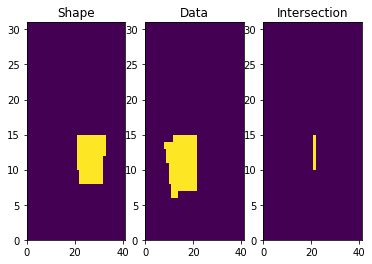

In [223]:
s_mask = area.cube_2d_weights(cube)
plt.subplot(131)
plt.pcolormesh(s_mask.data)
plt.gca().set_title("Shape")
plt.subplot(132)
plt.pcolormesh(np.invert(cube.data.mask))
plt.gca().set_title("Data")

intersection = s_mask.data * np.invert(cube.data.mask)
plt.subplot(133)
plt.pcolormesh(intersection)
plt.gca().set_title("Intersection")

print(np.sum(intersection))
print(np.sum(s_mask.data))
print(np.sum(intersection) / np.sum(s_mask.data))

print(check_data_shape_intersection(cube, area))

In [135]:
print((intersection == s_mask.data).all())
int = shape.cube_bbox_shape_intersection(cube, area)
int == area


True


False

1.0


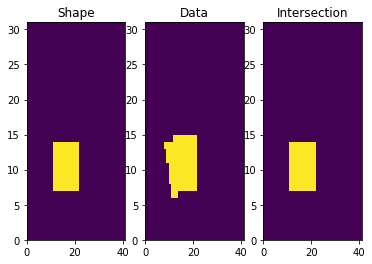

In [225]:
alp_shp = shape.load_shp('/net/home/h02/tcrocker/code/EUCP_WP5_Lines_of_Evidence/shape_files/EUCP_WP3_domains/EUCP_WP3_domains.shp', name="ALP-3")[0]
s_mask = alp_shp.cube_2d_weights(cube)
plt.subplot(131)
plt.pcolormesh(s_mask.data)
plt.gca().set_title("Shape")
plt.subplot(132)
plt.pcolormesh(np.invert(cube.data.mask))
plt.gca().set_title("Data")

intersection = s_mask.data * np.invert(cube.data.mask)
plt.subplot(133)
plt.pcolormesh(intersection)
plt.gca().set_title("Intersection")

print(check_data_shape_intersection(cube, alp_shp))

In [132]:
print((intersection == s_mask.data).all())

True


In [202]:

# read data
cmip5 = pd.read_csv(f'{BASE_PATH}CMIP5_{SEASON}.txt', sep=':', header=None)
cmip6 = pd.read_csv(f'{BASE_PATH}CMIP6_{SEASON}.txt', sep=':', header=None)
cordex = pd.read_csv(f'{BASE_PATH}CORDEX_{SEASON}.txt', sep=':', header=None)
cpm = pd.read_csv(f'{BASE_PATH}CPM_{SEASON}.txt', sep=':', header=None)
ukcp_g = pd.read_csv(f'{BASE_PATH}UKCP_gcm_{SEASON}.txt', sep=':', header=None)
ukcp_r = pd.read_csv(f'{BASE_PATH}UKCP_rcm_{SEASON}.txt', sep=':', header=None)

# List of models for Romania case study
niculita_model_list = [
    'RCA4 MPI-M-MPI-ESM-LR',
    'RCA4 MOHC-HadGEM2-ES',
    'RCA4 ICHEC-EC-EARTH',
    'RCA4 CNRM-CERFACS-CNRM-CM5',
    'REMO2009 MPI-M-MPI-ESM-LR',
    'RACMO22E MOHC-HadGEM2-ES',
    'RACMO22E ICHEC-EC-EARTH', 
    'HIRHAM5 ICHEC-EC-EARTH',
    ]

# list of models with evolving aerosols. See table B2 from:
# Gutiérrez, C., Somot, S., Nabat, P., Mallet, M., Corre, L., Van Meijgaard, E., et al. (2020). Future evolution of surface solar radiation and photovoltaic potential in Europe: investigating the role of aerosols. Environmental Research Letters, 15(3). https://doi.org/10.1088/1748-9326/ab6666
aerosol_model_list = []
for c in cordex[0]:
    if any([s in c for s in ['RACMO22E', 'ALADIN', 'HadREM3']]):
        aerosol_model_list.append(c)

case_study_model_list = aerosol_model_list

# This dictionary maps CPM string to a RCM GCM string
CPM_DRIVERS = {
    'CNRM-AROME41t1': 'ALADIN63 CNRM-CERFACS-CNRM-CM5',
    'CLMcom-CMCC-CCLM5-0-9': 'CCLM4-8-17 ICHEC-EC-EARTH',
    'HCLIMcom-HCLIM38-AROME': 'HCLIMcom-HCLIM38-ALADIN ICHEC-EC-EARTH',
    'GERICS-REMO2015': 'REMO2015 MPI-M-MPI-ESM-LR',
    'COSMO-pompa': 'CCLM4-8-17 MPI-M-MPI-ESM-LR',
    'ICTP-RegCM4-7-0': 'ICTP-RegCM4-7-0 MOHC-HadGEM2-ES',
    'ICTP-RegCM4-7': 'ICTP-RegCM4-7-0 MOHC-HadGEM2-ES',
    'KNMI-HCLIM38h1-AROME': 'KNMI-RACMO23E KNMI-EC-EARTH',
    'SMHI-HCLIM38-AROME': 'SMHI-HCLIM38-ALADIN ICHEC-EC-EARTH',
    'HadREM3-RA-UM10.1': 'MOHC-HadGEM3-GC3.1-N512 MOHC-HadGEM2-ES'
}

# List of CPM drivers from CORDEX to know which to plot as triangles
cpm_driver_list = []
for n in cpm[0]:
    cpm_driver_list.append(CPM_DRIVERS[n.split()[0]])

# map WP2 data to GCM group
wp2_methods = {
    "ETHZ_CMIP6_ClimWIP": "CMIP6",
    "ICTP_CMIP6_REA": "CMIP6",
    "ICTP_CMIP5_REA": "CMIP5",
    "UKMO_CMIP6_UKCP": "UKCP_GCM"
}

# set colours
colour_map = {
    "CMIP6": "tab:blue",
    "CMIP5": "tab:orange",
    "CORDEX": "tab:green",
    "CPM": "tab:red",
    "UKCP_GCM": "tab:purple",
}

# create data frame of just CPM drivers
cpm_driver_df = cordex[cordex[0].isin(cpm_driver_list)]
# create subset of models used in paper (this is only needed for the Romania case study)
case_study_df = cordex[cordex[0].isin(case_study_model_list)]

# CMIP5 CORDEX drivers can be inferred directly from CORDEX model names
cordex_driver_list = list(
    set(
        [remove_institute_from_driver(n.split(' ')[1]) for n in cordex[0]]
    )
)
cordex_driver_df = cmip5[cmip5[0].isin(cordex_driver_list)]

# chuck everything in a dataframe for plotting
plot_df = pd.DataFrame(
    {
        "CMIP6": cmip6[1],
        "CMIP5": cmip5[1],
        "CORDEX Drivers": cordex_driver_df[1],
        "CORDEX": cordex[1],
        "Case study models": case_study_df[1],
        "CPM Drivers": cpm_driver_df[1],
        "CPM": cpm[1],
        "UKCP_GCM": ukcp_g[1],
        "UKCP_RCM": ukcp_r[1],
        "UKCP Drivers": ukcp_g[ukcp_g[0].isin(ukcp_r[0])][1],
    }
)

# my calculated ClimWIP data - not using for now
# pr_cmip5_climwip = iris.load_cube(CLIMWIP_PATH)

# Set area to extract for plots
area = shape.load_shp(
    '/home/h02/tcrocker/code/EUCP_WP5_Lines_of_Evidence/shape_files/EUCP_WP3_domains/EUCP_WP3_domains.shp',
    name = AREA
)[0]
# ALP-3
# if AREA == "ALP-3":
#     area = [1, 17, 40, 50]
# else:
# # CEE-3
#     area = [18, 31, 41.5, 51.5]

# load WP2 atlas constraint data
constraint_data = {}
for m in wp2_methods.keys():
    constraint_data[m] = load_wp2_atlas(m, VAR, area, SEASON)

# also load Glen's UKCP data
constraint_data["UKMO_CMIP6_UKCP"] = load_wp2_glen(VAR, area, SEASON)

/net/project/ukmo/scitools/opt_scitools/environments/default/2021_03_18-1/lib/python3.6/site-packages/iris/analysis/cartography.py:394: UserWarning: Using DEFAULT_SPHERICAL_EARTH_RADIUS.
  warnings.warn("Using DEFAULT_SPHERICAL_EARTH_RADIUS.")
/net/project/ukmo/scitools/opt_scitools/environments/default/2021_03_18-1/lib/python3.6/site-packages/iris/analysis/cartography.py:394: UserWarning: Using DEFAULT_SPHERICAL_EARTH_RADIUS.
  warnings.warn("Using DEFAULT_SPHERICAL_EARTH_RADIUS.")
/net/project/ukmo/scitools/opt_scitools/environments/default/2021_03_18-1/lib/python3.6/site-packages/iris/analysis/cartography.py:394: UserWarning: Using DEFAULT_SPHERICAL_EARTH_RADIUS.
  warnings.warn("Using DEFAULT_SPHERICAL_EARTH_RADIUS.")
/net/project/ukmo/scitools/opt_scitools/environments/default/2021_03_18-1/lib/python3.6/site-packages/iris/analysis/cartography.py:394: UserWarning: Using DEFAULT_SPHERICAL_EARTH_RADIUS.
  warnings.warn("Using DEFAULT_SPHERICAL_EARTH_RADIUS.")
/net/project/ukmo/scitoo

In [204]:
plt.rcParams.update({'font.size': 14})
# create figure and axes
if len(case_study_model_list) > 0:
    f, axs = plt.subplots(1,4, sharey=True, figsize=[19.2 ,  9.77], gridspec_kw={'width_ratios': [3, 2, 4, 1]})
else:
    f, axs = plt.subplots(1,3, sharey=True, figsize=[19.2 ,  9.77], gridspec_kw={'width_ratios': [3, 2, 4]})
# f.suptitle("Projected % change in summer (JJA) rainfall for Romania. 2041-2060 vs 1995-2014. RCP8.5/ssp585")
# size of dots in swarm plots
swarm_size = 7

In [205]:
# First panel
# plot GCM boxes
axs[0].clear()

# plot boxes with matplotlib
box_plot([cmip6[1], cmip5[1], ukcp_g[1]], axs[0], "black", "None", [0, 1, 2], [0.5, 0.5, 0.5])

# plot dots
sns.swarmplot(
    data=plot_df[["CMIP6", "CMIP5", "UKCP_GCM"]], ax=axs[0],
    size=swarm_size, palette=["tab:blue", "tab:orange", "tab:purple"],
    alpha=0.75
    )

# last bits of formatting
axs[0].axhline(linestyle=":", color="k", alpha=0.5)
plt.setp(axs[0].get_xticklabels(), rotation=45, ha="right")
axs[0].set_title("GCMs")

Text(0.5, 1.0, 'GCMs')

In [206]:
# plot constrained ranges. 2nd panel
axs[1].clear()
for i, k in enumerate(constraint_data.keys()):
    colour = colour_map[wp2_methods[k]]
    # constrained
    bxp([constraint_data[k][0]], axs[1], colour, 0.75, [i], 0.375)
    # unconstrained
    bxp([constraint_data[k][1]], axs[1], colour, 0.25, [i], 0.5)

# This is for my custom ClimWIP data, not using for now
# box_plot([pr_cmip5_climwip[2].data], axs[1], "grey", "lightgrey", [1], [0.375])
# axs[0].boxplot(
#     x=[cmip6[1], cmip5[1], pr_cmip5_climwip[2].data],
#     positions=[0, 1, 1],
#     whis=[10,90],
#     showfliers=False,
#     widths=[0.5, 0.5, 0.375],
#     patch_artist=True
# )

axs[1].axhline(linestyle=":", color="k", alpha=0.5)
plt.setp(axs[1].get_xticklabels(), rotation=45, ha="right")
axs[1].set_title("Uncertainty estimates\nfrom GCMs and observations")

Text(0.5, 1.0, 'Uncertainty estimates\nfrom GCMs and observations')

In [207]:
# third panel downscaled information
axs[2].clear()
sns.swarmplot(
    data=plot_df[["CMIP5", "CORDEX", "CPM", "UKCP_GCM", "UKCP_RCM"]], 
    ax=axs[2],
    size=swarm_size,
    palette=["tab:orange", "tab:green", "tab:red", "tab:purple", "tab:purple"]
)
# CORDEX drivers
y = plot_df["CORDEX Drivers"].dropna()
x = create_x_points(y, 0.5, 0.05)
axs[2].scatter(x, y, color="tab:orange", marker=">", s=50)

# CPM drivers
y = plot_df["CPM Drivers"].dropna()
x = create_x_points(y, 1.5, 0.05)
axs[2].scatter(x, y, color="tab:green", marker=">", s=50)

# Divider line for UKCP
axs[2].axvline(2.5, color="lightgrey")

# UKCP drivers
y = plot_df["UKCP Drivers"].dropna()
x = create_x_points(y, 3.5, 0.05)
axs[2].scatter(x, y, color="tab:purple", marker=">", s=50)

# Final formatting etc.
axs[2].axhline(linestyle=":", color="k", alpha=0.5)
plt.setp(axs[2].get_xticklabels(), rotation=45, ha="right")
axs[2].set_title("Downscaled Projections")

Text(0.5, 1.0, 'Downscaled Projections')

In [208]:
# extra panel if a case study
if len(case_study_model_list) > 0:
    axs[3].clear()
    sns.swarmplot(
        data = plot_df["Case study models"],
        ax=axs[3],
        size=swarm_size,
        palette=["tab:green"]
        )
    axs[3].set_xticklabels(["Case study models"])
    axs[3].axhline(linestyle=":", color="k", alpha=0.5)
    plt.setp(axs[3].get_xticklabels(), rotation=45, ha="right")
    axs[3].set_title("From study")


In [209]:
# Final figure spacing etc.
# axs[0].set_ylabel("%")
plt.suptitle(f"{AREA} {SEASON} {VAR}")
plt.tight_layout()
plt.subplots_adjust(bottom=0.18, wspace=0.06)